In [35]:
import pandas as pd
pd.set_option('float_format', '{:.6f}'.format)

import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import kurtosis, skew

import umap

import seaborn as sns

from os.path import isfile
import pickle
import lzma

import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

In [5]:
def get_predictors_info(in_df: pd.DataFrame):
    result = {}

    df_len = in_df.shape[0]

    for col in in_df.columns.values:    
        current_predictor_info = {}

        is_discrete = False
        
        no_nan_series = in_df[col].loc[~in_df[col].isna()]

        current_series_difs = np.array([(x - round(x)) for x in no_nan_series])
        
        if current_series_difs.sum() == 0:
            is_discrete = True
        
        unique_in_series = sorted(np.unique(no_nan_series))

        may_be_category = False

        for idx, value in enumerate(unique_in_series[:-1:]):
            if (value + 1) == unique_in_series[idx + 1] and value >= 0:
                may_be_category = True
            else:
                may_be_category = False

        zeros_count = no_nan_series.isin([0]).sum()

        is_sparse = False

        if zeros_count / df_len > 0.5:
            is_sparse = True
            
        uniques_info = (len(unique_in_series), round(len(unique_in_series)/df_len * 100.0, ndigits=1))

        result[col] = [is_discrete, may_be_category, uniques_info, is_sparse]
    
    return pd.DataFrame(result, index=['Is discrete', 'Is sequential', 'Unique values (count, % of total)', 'Is sparce']).T

In [52]:
def make_experiment(experiment_number: int, dataset: pd.DataFrame, class_column: str, title: str):
    
    X = dataset.drop([class_column], axis=1)
    y = dataset[[class_column]]

    experiment_cv_scoes = list()

    score_file_name = "./data/models/rf_test_" + str(experiment_number) + ".xz"

    print("Experiment #{}:".format(experiment_number))
    print(title)

    if isfile(score_file_name):
        with lzma.open(score_file_name, "rb") as m_file:
            experiment_cv_scoes = pickle.load(m_file)
            print("\tCV scores loaded.")
    else:
        print("\tNo CV scores, calculating.")
        clf = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)

        cross_val = RepeatedStratifiedKFold(n_splits=4, random_state=42,)

        experiment_cv_scoes = cross_val_score(estimator=clf, X=X, y=y.to_numpy().flatten(), cv=cross_val, scoring='roc_auc')
            
        with lzma.open(score_file_name, "wb") as m_file:
            pickle.dump(experiment_cv_scoes, m_file)
            print("\tCV scores saved.")

    print("\tMean CV score is: {}".format(experiment_cv_scoes.mean()))

**Импорт данных**

In [7]:
src_df = pd.read_csv(filepath_or_buffer='./data/pima-indians-diabetes.csv')
src_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = src_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

**Дискретность, последовательность, разряженность**

In [8]:
src_df_info = get_predictors_info(src_df.drop(['Class'], axis=1))
src_df_info

,Is discrete,Is sequential,"Unique values (count, % of total)",Is sparce
Pregnancies,True,False,"(17, 2.2)",False
Glucose,True,True,"(135, 17.6)",False
BloodPressure,True,False,"(46, 6.0)",False
SkinThickness,True,False,"(50, 6.5)",False
Insulin,True,False,"(185, 24.1)",False
BMI,False,False,"(247, 32.2)",False
DiabetesPedigreeFunction,False,False,"(517, 67.3)",False
Age,True,False,"(52, 6.8)",False


**NaN**

In [9]:
src_df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Class                         0
dtype: int64

**Импутация**

In [10]:
imputer = MissForest(max_iter=10, random_state=42, verbose=0)
    
imputed_values = imputer.fit_transform(src_df.drop(['Class'], axis=1))
imputed_df = pd.DataFrame(data=imputed_values, columns=src_df.drop(['Class'], axis=1).columns.values).join(src_df[['Class']])

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


Собственно исследование на дискретность мне нужно было, чтобы понять, какие предикторы можно округлить до int. Что должно снижать шум от ипутации. Скорее всего.

In [11]:
for col in src_df_info['Is discrete'].index:
    if src_df_info['Is discrete'][col]:
        imputed_df[col] = imputed_df[col].map(round)
        #print(col)

get_predictors_info(imputed_df.drop(['Class'], axis=1))

,Is discrete,Is sequential,"Unique values (count, % of total)",Is sparce
Pregnancies,True,False,"(17, 2.2)",False
Glucose,True,True,"(135, 17.6)",False
BloodPressure,True,False,"(53, 6.9)",False
SkinThickness,True,False,"(50, 6.5)",False
Insulin,True,False,"(286, 37.2)",False
BMI,False,False,"(258, 33.6)",False
DiabetesPedigreeFunction,False,False,"(517, 67.3)",False
Age,True,False,"(52, 6.8)",False


In [12]:
imputed_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Class                       0
dtype: int64

**Распределения**

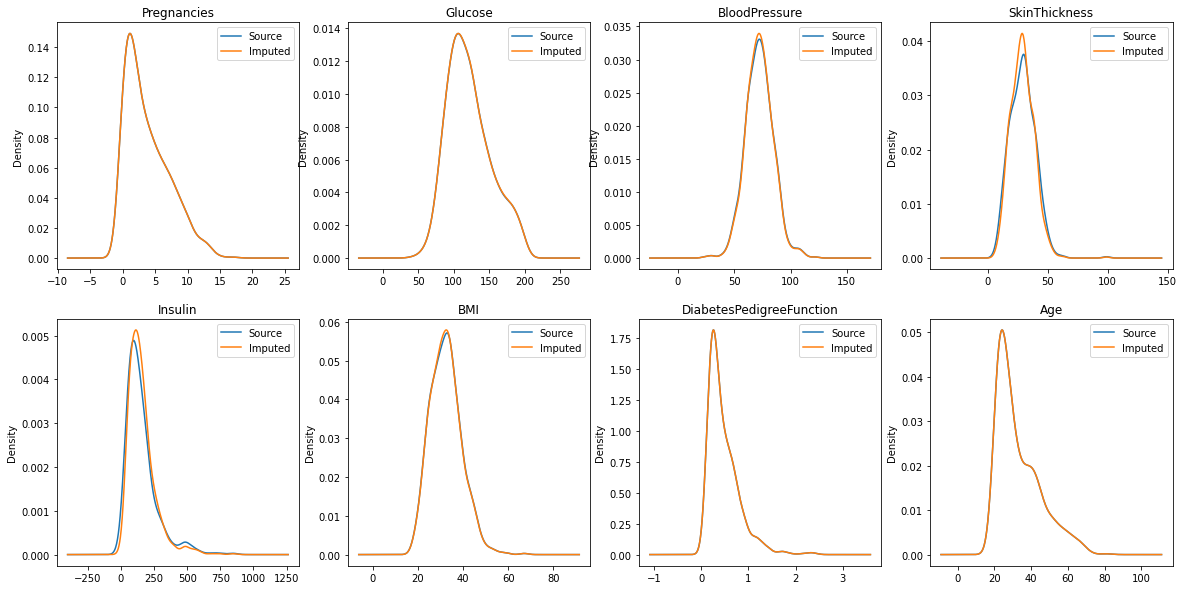

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
ax = axs.flatten()

for idx, col in enumerate(imputed_df.drop(['Class'], axis=1).columns.values):
    src_df[col].plot.density(ax=ax[idx])
    imputed_df[col].plot.density(ax=ax[idx])
    ax[idx].legend(['Source', 'Imputed'])
    ax[idx].set_title(col)

**Skewness & Kurtosis**

In [14]:
distribution_values = {}

for idx, col in enumerate(imputed_df.drop(['Class'], axis=1).columns.values):
    distribution_values[col] = [skew(imputed_df[col]), kurtosis(imputed_df[col])]
    
pd.DataFrame(data=distribution_values, index=['Skewness', 'Kurtosis']).T

,Skewness,Kurtosis
Pregnancies,0.899912,0.150383
Glucose,0.531464,-0.283699
BloodPressure,0.137197,0.982394
SkinThickness,0.695674,2.999344
Insulin,2.075999,6.755385
BMI,0.604255,0.899542
DiabetesPedigreeFunction,1.916159,5.550792
Age,1.127389,0.631177


**Experiment #1**

In [15]:
make_experiment(1, imputed_df, 'Class', 'Imputed with MissForest.')

Experiment #1:
Imputed with MissForest.
	CV scores loaded.
	Mean CV score is: 0.8281268656716417


**Scaling + Yeo Johnson (PowerTransformer)**

In [16]:
scaled_values = PowerTransformer().fit_transform(imputed_df.drop(['Class'], axis=1))
scaled_df = pd.DataFrame(data=scaled_values, columns=imputed_df.drop(['Class'], axis=1).columns.values).join(imputed_df[['Class']])

In [17]:
make_experiment(2, scaled_df, 'Class', 'Scaled with PowerTransformer.')

Experiment #2:
Scaled with PowerTransformer.
	CV scores loaded.
	Mean CV score is: 0.8277626865671642


**StandardScaler**

In [18]:
z_scaled_values = StandardScaler().fit_transform(imputed_df.drop(['Class'], axis=1))
z_scaled_df = pd.DataFrame(data=z_scaled_values, columns=imputed_df.drop(['Class'], axis=1).columns.values).join(imputed_df[['Class']])

In [19]:
make_experiment(3, z_scaled_df, 'Class', 'Scaled with StandatdScaler.')

Experiment #3:
Scaled with StandatdScaler.
	CV scores loaded.
	Mean CV score is: 0.8282134328358209


**Сравнение**

In [20]:
distribution_values = {}

for idx, col in enumerate(z_scaled_df.drop(['Class'], axis=1).columns.values):
    distribution_values[col] = [skew(z_scaled_df[col]), skew(scaled_df[col]), kurtosis(z_scaled_df[col]), kurtosis(scaled_df[col])]
    
pd.DataFrame(data=distribution_values, index=['Skewness StandardScaler', 'Skewness PowerTransformer', 'Kurtosis StandardScaler', 'Kurtosis PowerTransformer']).T

,Skewness StandardScaler,Skewness PowerTransformer,Kurtosis StandardScaler,Kurtosis PowerTransformer
Pregnancies,0.899912,-0.044557,0.150383,-0.989546
Glucose,0.531464,-0.001635,-0.283699,-0.252796
BloodPressure,0.137197,0.055911,0.982394,1.008987
SkinThickness,0.695674,0.014884,2.999344,0.503556
Insulin,2.075999,0.006106,6.755385,0.342813
BMI,0.604255,-0.000309,0.899542,-0.089159
DiabetesPedigreeFunction,1.916159,0.142043,5.550792,-0.885275
Age,1.127389,0.149926,0.631177,-1.206163


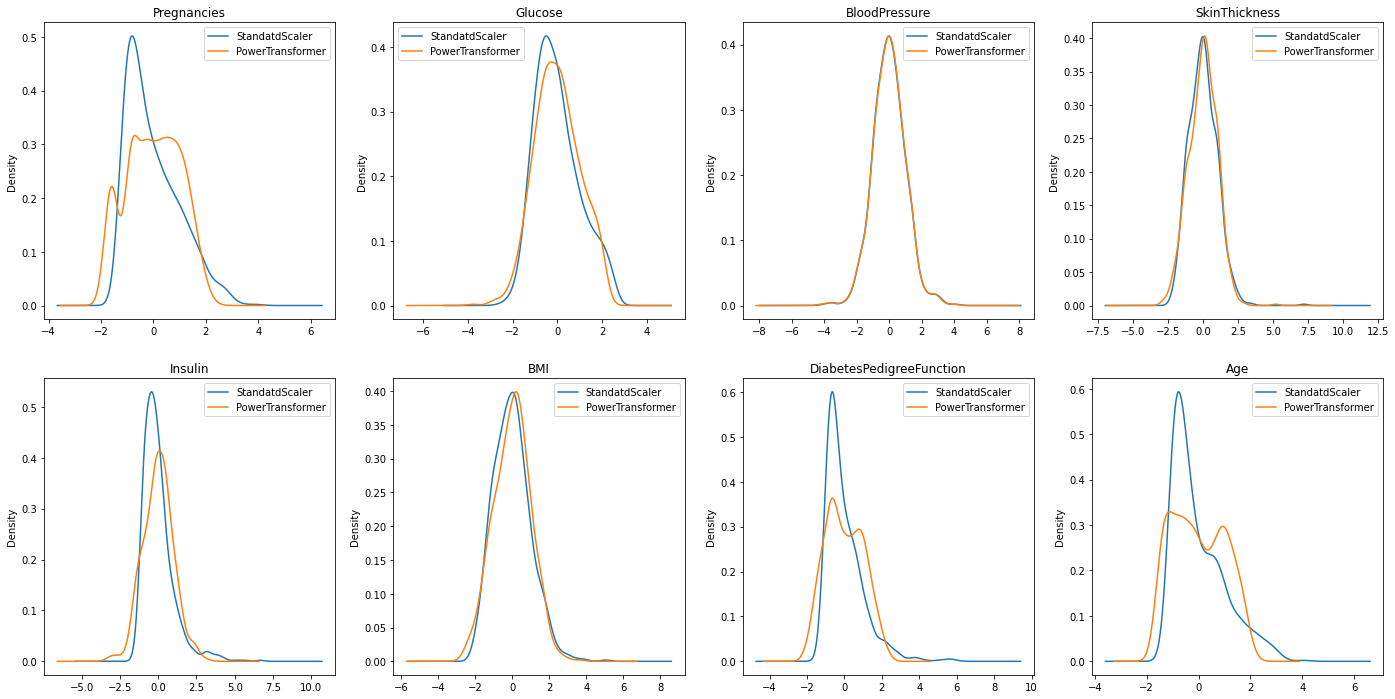

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(24, 12))
ax = axs.flatten()

for idx, col in enumerate(scaled_df.drop(['Class'], axis=1).columns.values):
    z_scaled_df[col].plot.density(ax=ax[idx])
    scaled_df[col].plot.density(ax=ax[idx])
    ax[idx].set_title(col)
    ax[idx].legend(['StandatdScaler', 'PowerTransformer'])
    ax[idx].set_title(col)

**Correlations**

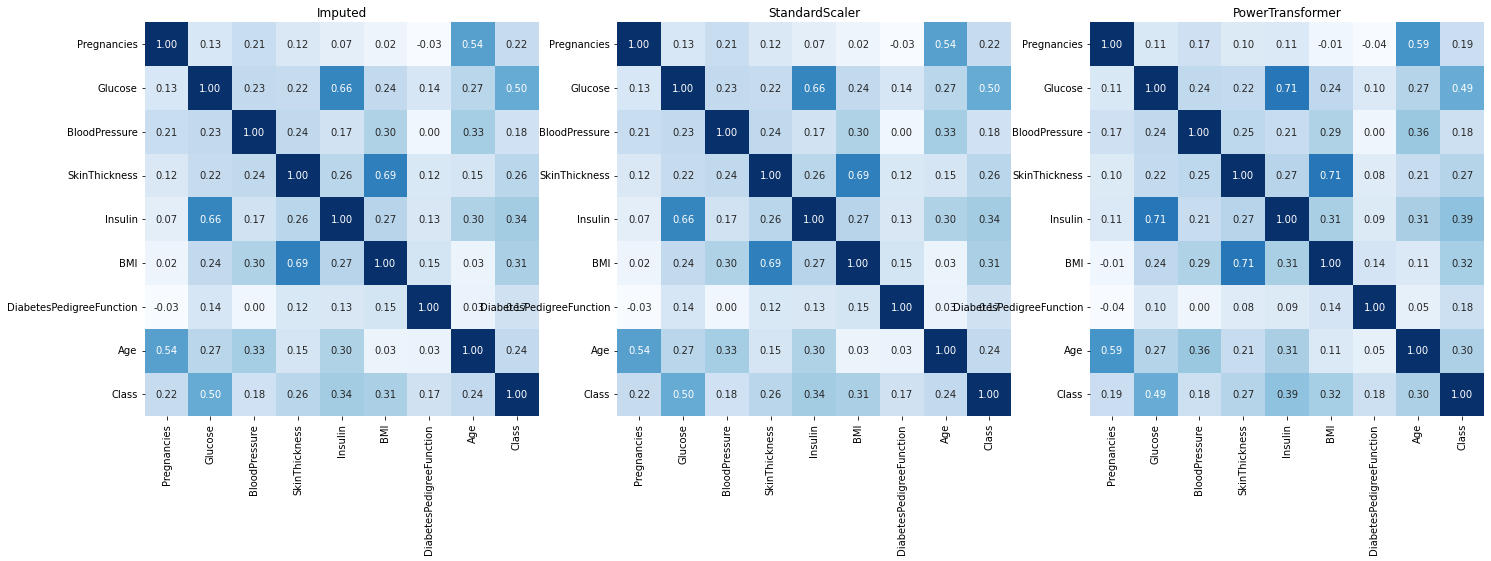

In [22]:
fig = plt.figure(figsize=(24,8))

plt.subplot(131)
plt.title('Imputed')
sns.heatmap(imputed_df.corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False)


plt.subplot(132)
plt.title('StandardScaler')
sns.heatmap(z_scaled_df.corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False)

plt.subplot(133) 
plt.title('PowerTransformer')
sns.heatmap(scaled_df.corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False)

plt.show()

**N-dimension PCA, TSNE, UMAP**

In [38]:
df_columns = imputed_df.drop(['Class'], axis=1).columns.values
imputed_no_class_values = imputed_df.drop(['Class'], axis=1).to_numpy()
scaled_no_class_values = scaled_df.drop(['Class'], axis=1).to_numpy()
z_scaled_no_class_values = z_scaled_df.drop(['Class'], axis=1).to_numpy()

In [31]:
PCA_8 = {}
PCA_8['imputed'] = PCA(n_components=8, random_state=42)
PCA_8['imputed'].fit(X=imputed_no_class_values)

PCA_8['StandardScaler'] = PCA(n_components=8, random_state=42)
PCA_8['StandardScaler'].fit(X=z_scaled_no_class_values)

PCA_8['PowerTransformer'] = PCA(n_components=8, random_state=42)
PCA_8['PowerTransformer'].fit(X=scaled_no_class_values)

PCA(n_components=8, random_state=42)

In [25]:
#TSNE_8 = {}
#TSNE_8['imputed'] = TSNE(n_components=8, random_state=42, method='exact').fit_transform(X=imputed_no_class_values)
#TSNE_8['StandardScaler'] = TSNE(n_components=8, random_state=42, method='exact').fit_transform(X=z_scaled_no_class_values)
#TSNE_8['PowerTransformer'] = TSNE(n_components=8, random_state=42, method='exact').fit_transform(X=scaled_no_class_values)

In [26]:
#UMAP_8 = {}
#UMAP_8['imputed'] = umap.UMAP(n_components=8, random_state=42).fit_transform(X=imputed_no_class_values)
#UMAP_8['StandardScaler'] = umap.UMAP(n_components=8, random_state=42).fit_transform(X=z_scaled_no_class_values)
#UMAP_8['PowerTransformer'] = umap.UMAP(n_components=8, random_state=42).fit_transform(X=scaled_no_class_values)

In [47]:
pd.DataFrame(
    data=[PCA_8['imputed'].explained_variance_ratio_, PCA_8['StandardScaler'].explained_variance_ratio_, PCA_8['PowerTransformer'].explained_variance_ratio_],
    columns=df_columns,
    index = ['imputed', 'StandardScaler', 'PowerTransformer']
    )

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
imputed,0.924385,0.042086,0.014910,0.009546,0.006964,0.001471,0.000630,0.000009
StandardScaler,0.327480,0.186811,0.147677,0.116490,0.092651,0.054911,0.039371,0.034610
PowerTransformer,0.338537,0.185357,0.146208,0.120106,0.095735,0.046056,0.036771,0.031230


In [53]:
make_experiment(4, scaled_df.drop(['DiabetesPedigreeFunction', 'Age'], axis=1), 'Class', 'Scaled with StandatdScaler.')

Experiment #4:
Scaled with StandatdScaler.
	No CV scores, calculating.
	CV scores saved.
	Mean CV score is: 0.8036552238805971
